<a href="https://colab.research.google.com/github/valthoraval/stochastic/blob/master/Project_Market_Day_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)

It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits? 

In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.

Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:

In [3]:
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
!pip install pymoo

--2022-12-13 12:08:26--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927 [text/plain]
Saving to: ‘market.csv’

market.csv          100%[===================>]     927  --.-KB/s    in 0s      

2022-12-13 12:08:26 (59.6 MB/s) - ‘market.csv’ saved [927/927]

--2022-12-13 12:08:26--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388 [text/plain]
Savin

In [4]:
import numpy as np
import pandas as pd
import pymoo
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import random

In [5]:
df = pd.read_csv('market.csv', index_col=0)
df.head()

,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [6]:
stock = df['stock'].to_dict()
weight = df['weight'].to_dict()
price = df['price_A'].to_dict()

In [7]:
stock

{'Apple': 5,
 'Apricot': 65,
 'Blueberry': 5,
 'Cactus Fruit': 90,
 'Cherry': 15,
 'Cranberry': 75,
 'Grape': 70,
 'Melon': 75,
 'Orange': 40,
 'Peach': 55,
 'Pomegranate': 5,
 'Rhubarb': 70,
 'Starfruit': 5,
 'Strawberry': 20,
 'Amaranth': 20,
 'Artichoke': 65,
 'Beet': 30,
 'Bok Choy': 55,
 'Cauliflower': 70,
 'Corn': 90,
 'Eggplant': 95,
 'Garlic': 95,
 'Green Bean': 55,
 'Hops': 75,
 'Hot Pepper': 25,
 'Kale': 5,
 'Parsnip': 10,
 'Potato': 55,
 'Pumpkin': 30,
 'Radish': 50,
 'Red Cabbage': 55,
 'Tomato': 65,
 'Wheat': 75,
 'Yam': 50,
 'Blackberry': 70}

To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.

In [8]:
def evaluate(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

You can try this with an example load generated randomly:

In [10]:
trial_load = {}

for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])

In [11]:
evaluate(trial_load, stock, weight, price)

694.8000000000002

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)

##Answer Challenge 1

A genetic algorithm was made to complete the first challenge.

First, we need a function to evaluate the fitness score for each individual in the population.

In [12]:
# Function to compute the fitness of all individuals in the population

def evaluate_population(population, price_1):
    fit = []
    for i in range(len(population)):
        prix = evaluate(population[i], stock, weight, price_1)
        fit.append(prix)
    return fit

Then, we select 20% of the population with the best fitness score.



In [13]:
# Select the best 20% individuals from the population

def truncation_selection(population, fitness, p=0.2):
    n_elites = len(population) - int(np.floor(len(population) * p))
    elites = np.argsort(np.array(fitness))[n_elites:]
    selected_pop, selected_fitness = [], []
    for index in elites:
        selected_pop.append(population[index])
        selected_fitness.append(fitness[index])
    return selected_pop, selected_fitness

We will need to select parents of the children of the next generation. To preserve genetic diversity, we make a tournament selection of each parent in the truncated population. 

In each case, we select 3 random individuals from the truncated population and keep the one with the highest fitness.

In [83]:
# Choose randomly 3 individuals and keep the one with the highest fitness

def tournament_selection(population, fitness, t_size=3):
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    ind = []
    for i in range(len(tournament)):
        ind.append(fitness[tournament[i]])
    ind = ind.index(max(ind))
    return population[ind], fitness[ind]

Once two parents are selected, their child will be a crossover of them, as shown below:

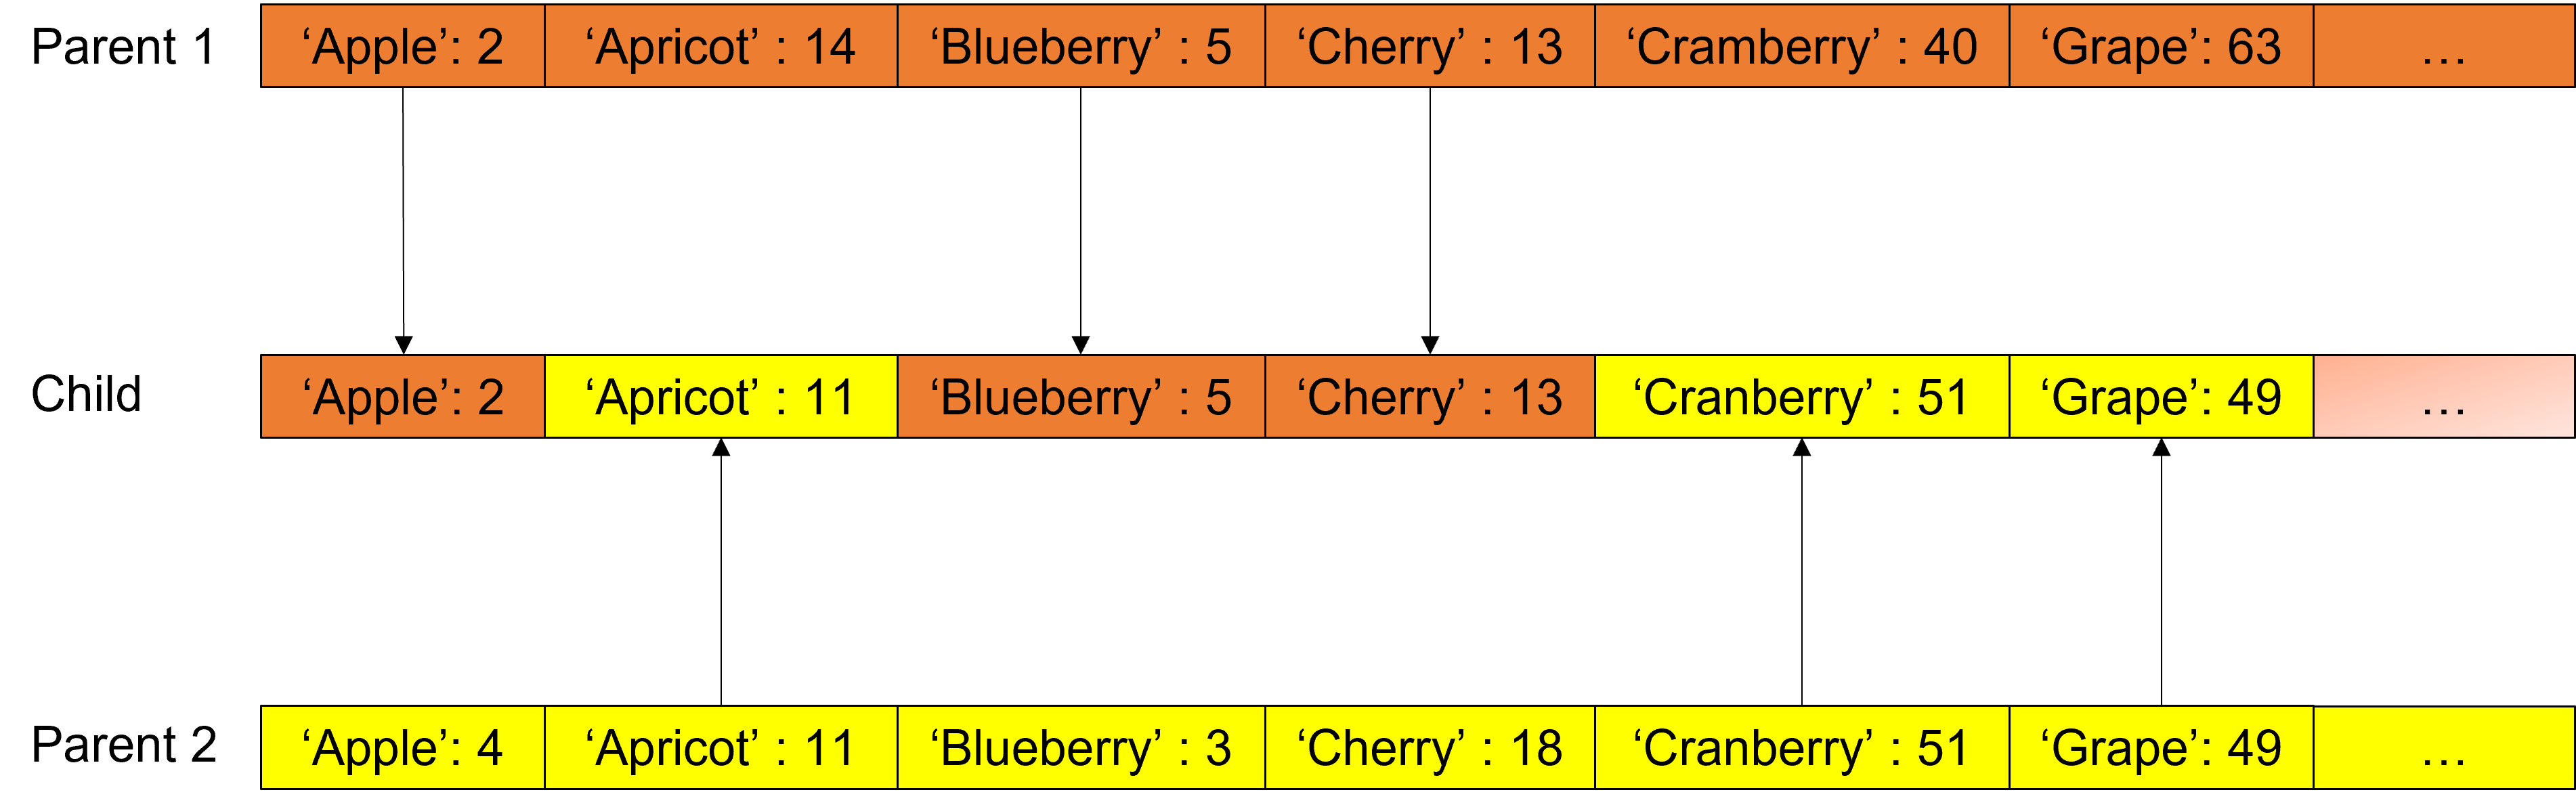

In [15]:
# Cross loaded items from two possible load 'parent1' and 'parent2' to get the 'child' load

def crossover(parent1, parent2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(parent1)-1, len(parent2)-1)))
    cross_list = list(np.zeros(len(parent1)))
    ind_list = random.sample(list(np.arange(len(parent1))),x)
    for index in ind_list:
        cross_list[index] = 1
    child = {}
    for i in range(len(parent1)):
        if cross_list[i] == 0:
            child[list(parent1.keys())[i]] = list(parent1.values())[i]
        else:
            child[list(parent2.keys())[i]] = list(parent2.values())[i]
    return child

Once we got a child, a mutation is performed to search for solutions outside of our selected population. Here, the mutation is simple, we add an item on a random crop and remove one from another random crop.

In [16]:
def mutate(indiv):
    rng = np.random.default_rng()
    continue_mutation = True
    while(continue_mutation):
        x = rng.choice(len(indiv)-1,2,replace=False)
        x1, x2 = x[0], x[1]
        # Check if we can add an element the x1 type crop 
        # and remove an element from the x2 type crop
        if((list(indiv.values())[x1]+1 < list(stock.values())[x1]) and
           (list(indiv.values())[x2]-1 > 0)):
              child = indiv.copy()
              child.update({str(list(indiv.keys())[x1]):list(indiv.values())[x1]+1})
              child.update({str(list(indiv.keys())[x2]):list(indiv.values())[x2]-1})
              continue_mutation = False
    return child

All these functions were compiled in the following function. For each generation, ga_step computes the next generation.

In [17]:
def ga_step(population, evaluate_population, prix):
    fitness = evaluate_population(population, prix)
    fp_fits = np.zeros(20)
    next_pop, _ = truncation_selection(population, fitness)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = crossover(parent1, parent2)
        child = mutate(child)
        next_pop.append(child)
    next_fitness = evaluate_population(next_pop, prix)
    return next_pop, next_fitness

We create a population with 100 possible crop loads.

In [18]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

Here is our genetic algorithm. We took 2000 generations.

The evolution of the maximum fitness score across generations is plotted.

It takes about 1 minute to run.

Best load :
{'Apple': 4, 'Apricot': 6, 'Blueberry': 1, 'Cactus Fruit': 89, 'Cherry': 14, 'Cranberry': 40, 'Grape': 69, 'Melon': 1, 'Orange': 39, 'Peach': 54, 'Pomegranate': 4, 'Rhubarb': 1, 'Starfruit': 0, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 64, 'Beet': 29, 'Bok Choy': 54, 'Cauliflower': 69, 'Corn': 89, 'Eggplant': 94, 'Garlic': 94, 'Green Bean': 45, 'Hops': 1, 'Hot Pepper': 24, 'Kale': 4, 'Parsnip': 9, 'Potato': 54, 'Pumpkin': 1, 'Radish': 49, 'Red Cabbage': 53, 'Tomato': 64, 'Wheat': 1, 'Yam': 49, 'Blackberry': 5}
Final price 1123.9500000000003


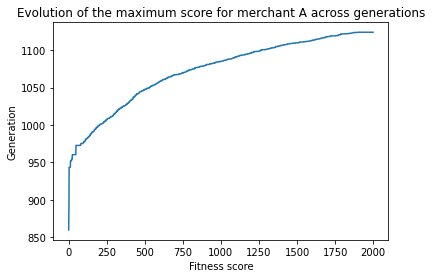

In [19]:
maxfit = []
n_gen = 2000
maxfit = np.zeros(n_gen)
pop = population_trail_load
best_pop = {}
for i in range(n_gen):
    pop, fitn = ga_step(pop, evaluate_population, price)
    maxfit[i] = np.max(fitn)
    if (i > 2) and (maxfit[i] > maxfit[i-1]):
        #print('Generation('+str(i)+') - Max score'+str(maxfit[i]))
        best_pop = pop
        ind = np.where(fitn == maxfit[i])[0][0]
        best_pop = pop[ind]
print('Best load :')
print(best_pop)
a = evaluate(best_pop, stock, weight, price)
print('Final price', a)

x = np.arange(n_gen)
fig = plt.figure()
plt.plot(x, maxfit)
plt.xlabel("Fitness score")
plt.ylabel("Generation")
plt.title("Evolution of the maximum score for merchant A across generations")
plt.show()


The graph above shows that most of the improvement in the fitness score is made in the first 100 generations. However, the score is still increasing at a logarithmic pace across the other generations. The convergence around the final score appears in the last 100 generations.

## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.

In [20]:
price_a = df['price_A'].to_dict()
price_b = df['price_B'].to_dict()
price_c = df['price_C'].to_dict()

In [21]:
price_a['Cherry'], price_b['Cherry'], price_c['Cherry']

(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:

In [22]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)

787.4000000000001 337.80000000000007 513.0


Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.

Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.

##Answer Challenge 2

For this second challenge, we change the evaluate_population function so that it can be used for each of the four options for the market day haul. If the input `price_2` is `all_three`, a mean of the price of each merchant is computed. Each price has the same weight in this function of 1/3.

In [23]:
def evaluate_population_2(population, price_2):
    fit = []
    for i in range(len(population)):
      if(price_2 != 'all_three'):
        prix_2 = evaluate(population[i], stock, weight, price_2)
        fit.append(prix_2)
      else:
        # Compute the mean fitness for each merchant
        prix_2 = evaluate(population[i], stock, weight, price_a) + evaluate(population[i], stock, weight, price_b) + evaluate(population[i], stock, weight, price_c)
        prix_2 = prix_2/3
        fit.append(prix_2)
    return fit

We create another population of 100 possible crop loads.

In [80]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

Here is our genetic algorithm. We took 2000 generations.

The evolution of the maximum fitness score across generations is plotted for each option for the market day haul.

It takes about 4 minutes to run.

Option : Price A ; Last generation : 1971 ; Highest score : 1119.9000000000003
Best load : {'Apple': 4, 'Apricot': 5, 'Blueberry': 4, 'Cactus Fruit': 87, 'Cherry': 14, 'Cranberry': 73, 'Grape': 69, 'Melon': 1, 'Orange': 39, 'Peach': 39, 'Pomegranate': 3, 'Rhubarb': 1, 'Starfruit': 1, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 64, 'Beet': 29, 'Bok Choy': 54, 'Cauliflower': 69, 'Corn': 89, 'Eggplant': 94, 'Garlic': 94, 'Green Bean': 35, 'Hops': 1, 'Hot Pepper': 17, 'Kale': 4, 'Parsnip': 9, 'Potato': 54, 'Pumpkin': 1, 'Radish': 49, 'Red Cabbage': 48, 'Tomato': 64, 'Wheat': 1, 'Yam': 49, 'Blackberry': 47} 

Option : Price B ; Last generation : 1994 ; Highest score : 455.1000000000002
Best load : {'Apple': 4, 'Apricot': 1, 'Blueberry': 4, 'Cactus Fruit': 8, 'Cherry': 14, 'Cranberry': 35, 'Grape': 1, 'Melon': 74, 'Orange': 39, 'Peach': 54, 'Pomegranate': 4, 'Rhubarb': 69, 'Starfruit': 0, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 51, 'Beet': 29, 'Bok Choy': 13, 'Cauliflower': 5, 'Cor

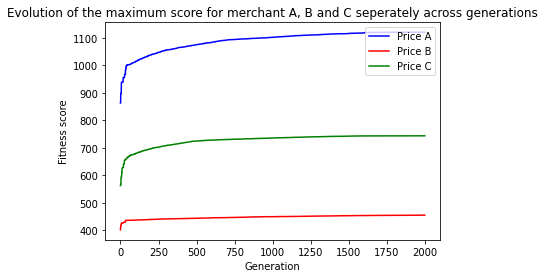

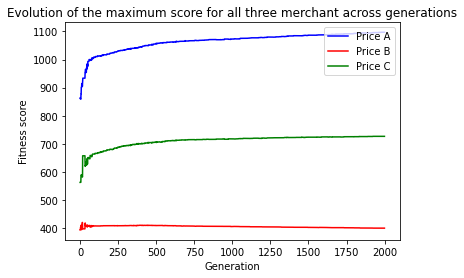

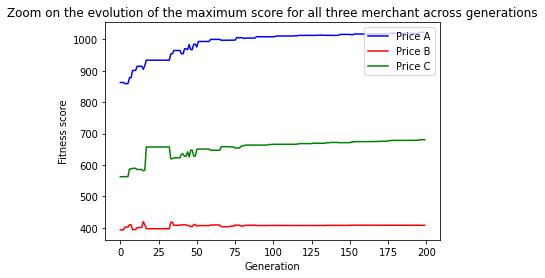

In [77]:
list_price = [price_a, price_b, price_c, 'all_three']
list_etiquette = ['Price A', 'Price B', 'Price C', 'All three']
list_col = ['b', 'r', 'g', 'k']
result_list = []
pop_list = []

for p in list_price:
    result = (0,0)
    n_gen = 2000
    maxfit = np.zeros(n_gen)
    pop = population_trail_load
    best_pop = {}
    for i in range(n_gen):
        pop, fitn = ga_step(pop, evaluate_population_2, p)
        maxfit[i] = np.max(fitn)
        if p == 'all_three':
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            pop_list.append(pop[ind])
        if (i > 2) and (maxfit[i] > maxfit[i-1]):
            result = (i, maxfit[i])
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            best_pop = pop[ind]
    result_list.append(maxfit)
    if p != 'all_three':
        print('Option : '+str(list_etiquette[list_price.index(p)])+
              ' ; Last generation : '+str(result[0])+' ; Highest score : ' +str(result[1]))
        print('Best load :', best_pop, '\n')

    else:
        a = evaluate(best_pop, stock, weight, price_a)
        b = evaluate(best_pop, stock, weight, price_b)
        c = evaluate(best_pop, stock, weight, price_c)
        print('Option : '+str(list_etiquette[list_price.index(p)])+
              ' ; Last generation : '+str(result[0])+' ; Highest score : ' +str((a, b, c)))
        print('Best load :', best_pop, '\n')

# Plot result of optimization on each price separetely
x = np.arange(n_gen)
fig = plt.figure()
for i in range(3):
    plt.plot(x, result_list[i], list_col[i], label=list_etiquette[i])
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend(loc='upper right')
plt.title("Evolution of the maximum score for merchant A, B and C seperately across generations")
plt.show()

# Plot result of optimization on all price together
fig = plt.figure()
for p in range(3):
    result_fit = np.zeros(n_gen)
    for ind, pop in enumerate(pop_list):
        result_fit[ind] = evaluate(pop, stock, weight, list_price[p])
    plt.plot(x, result_fit, list_col[p], label=list_etiquette[p])
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend(loc='upper right')
plt.title("Evolution of the maximum score for all three merchant across generations")
plt.show()

fig = plt.figure()
for p in range(3):
    result_fit = np.zeros(n_gen)
    for ind, pop in enumerate(pop_list):
        result_fit[ind] = evaluate(pop, stock, weight, list_price[p])
    plt.plot(x[:200], result_fit[:200], list_col[p], label=list_etiquette[p])
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend(loc='upper right')
plt.title("Zoom on the evolution of the maximum score for all three merchant across generations")
plt.show()


For the three first options, the first graph above shows that most of the improvement in the fitness score is made in the first 100 generations. The score is still increasing at a logarithmic pace across the other generations. The convergence around the final score seems to appear earlier with prices B and C than with price A. This is due to the scale effect related to the significant difference between the optimal values of each price.

For the options with all three merchants, we got naturally lower scores for each price compared to cases where they were optimized separately. The zoom on the first 200 generations shows that there are some oscillations in the maximum fitness score for each price, which disappear or are attenuated before the 100th generation. The evolution for price B is steady compared to price C and especially price A which both keep increasing at a logarithmic pace across generations.

This issue could be solved by choosing other coefficients of 1/3 in the ```
evaluate_population_2 ``` function on each price by instance by 17% in price A, 50% in price B, and 33% in price C, based on their individual optimal fitness score.



## Challenge 3

You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.

In [27]:
recipes = {'Ratatouille': {'Eggplant': 2, 'Garlic': 2, 'Tomato': 4, 'Hot Pepper': 1},
 'Apple Pie': {'Apple': 10, 'Wheat': 5},
 'Apricot Pie': {'Apricot': 10, 'Wheat': 5},
 'Cherry Pie': {'Cherry': 10, 'Wheat': 5},
 'Rhubarb Pie': {'Rhubarb': 10, 'Wheat': 5},
 'Strawberry Pie': {'Strawberry': 10, 'Wheat': 5},
 'Blackberry Pie': {'Blackberry': 10, 'Wheat': 5},
 'Pumpkin Pie': {'Pumpkin': 10, 'Wheat': 5},
 'Pizza': {'Tomato': 3, 'Wheat': 2, 'Artichoke': 1},
 'Baba Ghanoush': {'Eggplant': 2, 'Garlic': 4},
 'Squash Soup': {'Yam': 3, 'Pumpkin': 1},
 'Peach Beer': {'Hops': 3, 'Peach': 1},
 'Blackberry Beer': {'Hops': 3, 'Blackberry': 1}}

These recipes sell for good prices at each of the resellers:

In [28]:
df = pd.read_csv('recipes.csv', index_col=0)
df.head()

,price_A,price_B,price_C
Ratatouille,68.0,13.0,52.0
Apple Pie,146.0,84.0,176.0
Apricot Pie,81.0,46.0,110.0
Cherry Pie,120.0,72.0,176.0
Rhubarb Pie,133.0,162.0,98.0


In [29]:
price_a.update(df['price_A'].to_dict())
price_b.update(df['price_B'].to_dict())
price_c.update(df['price_C'].to_dict())
price_a['Apple Pie'], price_b['Apple Pie'], price_c['Apple Pie']

(146.0, 84.0, 176.0)

Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:

In [30]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load

{'Ratatouille': 3,
 'Apple Pie': 3,
 'Apricot Pie': 3,
 'Cherry Pie': 0,
 'Rhubarb Pie': 4,
 'Strawberry Pie': 1,
 'Blackberry Pie': 3,
 'Pumpkin Pie': 2,
 'Pizza': 2,
 'Baba Ghanoush': 0,
 'Squash Soup': 3,
 'Peach Beer': 2,
 'Blackberry Beer': 3}

In [31]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight

In [32]:
get_weight(recipe_load, recipes, weight)

1671

Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.

##Answer Challenge 3

A new ```
evaluate
``` function was created to include recipes in the final price. 

The load has the same as above. This function checks firstly if each recipe is feasible, that is if there are enough ingredients in the load. Then, the unused crops are evaluated.

In [34]:
def evaluate_with_recipes(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    final_load = load.copy()
    recipe_load = {}

    for r in recipes.keys():    
        ingredients = recipes[r]
        weight_recipe = 0
        nb_recipe = 0
        # Check if we can make the recipe with our numbers of ingredients
        list_ingredient = np.zeros(len(ingredients))
        for index, i in enumerate(ingredients):
            nb_ingredient = 0
            while nb_ingredient * ingredients[i] < final_load[i]:
                list_ingredient[index] = nb_ingredient
                nb_ingredient += 1
            if list_ingredient[index] == 0:
                break
        nb_recipe = np.min(list_ingredient)
        if nb_recipe != 0:
            for ing in ingredients:
                nb_ing = nb_recipe * ingredients[ing]
                final_load.update({str(ing) : final_load[ing] - nb_ing})
        recipe_load.update({str(r) : nb_recipe})
        total_price += nb_recipe * price[r]
    total_weight += get_weight(recipe_load, recipes, weight)

    for k in load:
        # Initial evaluation for the remaining elements in the final load
        if final_load[k] <= stock[k]:
            total_price += final_load[k] * price[k]
            total_weight += final_load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

From ```
evaluate_with_recipes
```, we create a new function 'evaluate population' (```
evaluation_population_3
```).

In [55]:
def evaluate_population_3(population, price_2):
    fit = []
    for i in range(len(population)):
      if(price_2 != 'all_three'):
        prix_2 = evaluate_with_recipes(population[i], stock, weight, price_2)
        fit.append(prix_2)
      else:
        prix_2 = evaluate_with_recipes(population[i], stock, weight, price_a) + evaluate_with_recipes(population[i], stock, weight, price_b) + evaluate_with_recipes(population[i], stock, weight, price_c)
        prix_2 = prix_2/3
        fit.append(prix_2)
    return fit

For the last time, we create a population of 100 possible crop loads.

In [78]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

Here is our genetic algorithm. We took 2000 generations.

The evolution of the maximum fitness score across generations, including recipe, is plotted for each options for the market day haul.

It takes about 14 minutes to run.

Option : Price A ; Last generation : 1995 ; Highest score : 5175.0999999999985
Best load : {'Apple': 1, 'Apricot': 11, 'Blueberry': 1, 'Cactus Fruit': 1, 'Cherry': 1, 'Cranberry': 1, 'Grape': 55, 'Melon': 1, 'Orange': 13, 'Peach': 25, 'Pomegranate': 1, 'Rhubarb': 61, 'Starfruit': 1, 'Strawberry': 11, 'Amaranth': 19, 'Artichoke': 64, 'Beet': 29, 'Bok Choy': 54, 'Cauliflower': 58, 'Corn': 64, 'Eggplant': 89, 'Garlic': 93, 'Green Bean': 37, 'Hops': 73, 'Hot Pepper': 10, 'Kale': 4, 'Parsnip': 8, 'Potato': 54, 'Pumpkin': 29, 'Radish': 48, 'Red Cabbage': 1, 'Tomato': 64, 'Wheat': 69, 'Yam': 49, 'Blackberry': 6} 

Option : Price B ; Last generation : 1699 ; Highest score : 3122.2
Best load : {'Apple': 4, 'Apricot': 21, 'Blueberry': 3, 'Cactus Fruit': 1, 'Cherry': 14, 'Cranberry': 1, 'Grape': 11, 'Melon': 21, 'Orange': 39, 'Peach': 49, 'Pomegranate': 4, 'Rhubarb': 66, 'Starfruit': 1, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 53, 'Beet': 29, 'Bok Choy': 8, 'Cauliflower': 2, 'Corn': 3, 'Egg

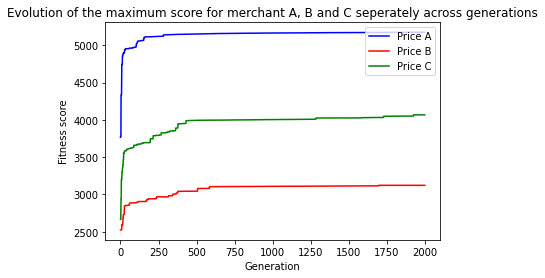

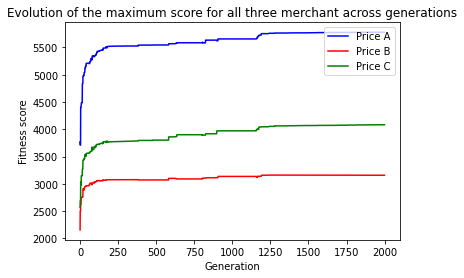

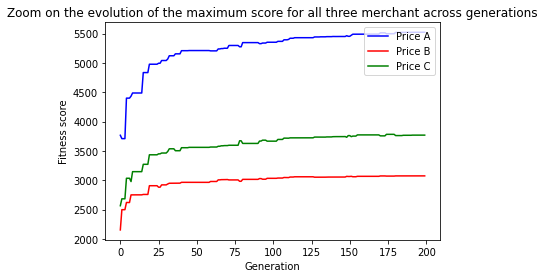

In [79]:
list_price = [price_a, price_b, price_c, 'all_three']
list_etiquette = ['Price A', 'Price B', 'Price C', 'All three']
list_col = ['b', 'r', 'g', 'k']
result_list = []
pop_list = []

for p in list_price:
    result = (0,0)
    n_gen = 2000
    maxfit = np.zeros(n_gen)
    pop = population_trail_load
    best_pop = {}
    for i in range(n_gen):
        pop, fitn = ga_step(pop, evaluate_population_3, p)
        maxfit[i] = np.max(fitn)
        if p == 'all_three':
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            pop_list.append(pop[ind])
        if (i > 2) and (maxfit[i] > maxfit[i-1]):
            result = (i, maxfit[i])
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            best_pop = pop[ind]
    result_list.append(maxfit)
    if p != 'all_three':
        print('Option : '+str(list_etiquette[list_price.index(p)])+
              ' ; Last generation : '+str(result[0])+' ; Highest score : ' +str(result[1]))
        print('Best load :', best_pop, '\n')
    else:
        a = evaluate_with_recipes(best_pop, stock, weight, price_a)
        b = evaluate_with_recipes(best_pop, stock, weight, price_b)
        c = evaluate_with_recipes(best_pop, stock, weight, price_c)
        print('Option : '+str(list_etiquette[list_price.index(p)])+
              ' ; Last generation : '+str(result[0])+' ; Highest score : ' +str((a, b, c)))
        print('Best load :', best_pop, '\n')

# Plot result of optimization on each price separetely
x = np.arange(n_gen)
fig = plt.figure()
for i in range(3):
    plt.plot(x, result_list[i], list_col[i], label=list_etiquette[i])
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend(loc='upper right')
plt.title("Evolution of the maximum score for merchant A, B and C seperately across generations")
plt.show()

# Plot result of optimization on all price together
fig = plt.figure()

for p in range(3):
    result_fit = np.zeros(n_gen)
    for ind, pop in enumerate(pop_list):
        result_fit[ind] = evaluate_with_recipes(pop, stock, weight, list_price[p])
    plt.plot(x, result_fit, list_col[p], label=list_etiquette[p])

plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend(loc='upper right')
plt.title("Evolution of the maximum score for all three merchant across generations")
plt.show()

fig = plt.figure()
for p in range(3):
    result_fit = np.zeros(n_gen)
    for ind, pop in enumerate(pop_list):
        result_fit[ind] = evaluate_with_recipes(pop, stock, weight, list_price[p])
    plt.plot(x[:200], result_fit[:200], list_col[p], label=list_etiquette[p])
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend(loc='upper right')
plt.title("Zoom on the evolution of the maximum score for all three merchant across generations")
plt.show()

As seen in previous challenges, for the three first options, the first graph above shows that most of the improvement in the fitness score is made in the first 100 generations. The score is still increasing at a logarithmic pace across the other generations. The convergence around the final score seems to appear earlier with prices A and B, even though some late leaps are visible for price B.

For the options with all three merchants, we got naturally lower scores for each price compared to cases where they were optimized separately. The zoom on the first 200 generations shows that there are some oscillations in the maximum fitness score for each price, which are attenuated in the long run as highlighted on the second graph. 

The second graph shows that the increase of the fitness score for price B is slight compared to price C and especially price A. This issue could be solved by taking other coefficients in the `evaluate_population_3` function on each price or using an NSGA-II.

It is interesting to notice, on the 2nd graph above, that the optimization on all prices the variation of each fitness score curve happened at the same generations.

## Evaluation

You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

Criterion | Points
--- | ---
Results - Challenge 1 | 7
Results - Challenge 2 | 5
Results - Challenge 3 | 3
Presentation (code, text) | 5